## Problem Statement

- The telecommunications industry faces high competition, with customers having the ability to select from various service providers and switch operators. As a result, telecom companies experience an average annual churn rate of 15-25%. 
- Retaining existing customers has become more crucial than acquiring new ones as the cost of acquisition is 5-10 times higher. 
- For incumbent operators, keeping profitable customers is their top priority. 
- To achieve this, telecom companies need to forecast which customers are at a greater risk of churning.

## Objective 

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

#### Loading Modules and Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Importing Data

In [3]:
# Importing dataset
telecom_df = pd.read_csv("telecom_churn_data.csv")

In [4]:
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
telecom_df.shape

(99999, 226)

#### In churn prediction, we assume that there are three phases of customer lifecycle :

The time period under consideration is divided into three phases: the 'good' phase which spans Month 6 and 7, the 'action' phase in Month 8, and the 'churn' phase in Month 9. As we are analyzing a four-month period, the initial two months fall under the 'good' phase, the third month is the 'action' phase, and the final month is the 'churn' phase.

### 1. Derive new features

In [6]:
#extract list of columns containing recharge amount

amt_recharge_columns =  telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


#### Analysis: From above features we can derive more meaningful information :

- Total recharge amount
- Total recharge for data
- Maximum recharge amount
- Last date of Recharging the data
- Average recharge amount for data

In [9]:
# Checking missing values percentages

telecom_null_check = 100*telecom_df.loc[:,amt_recharge_columns].isnull().sum()/len(telecom_df)
df = pd.DataFrame(telecom_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
display(df.sort_values(by='Null_Percentage', ascending=False))

,Null_Percentage
total_rech_data_6,74.846748
av_rech_amt_data_6,74.846748
max_rech_data_6,74.846748
date_of_last_rech_data_6,74.846748
av_rech_amt_data_7,74.428744
max_rech_data_7,74.428744
date_of_last_rech_data_7,74.428744
total_rech_data_7,74.428744
date_of_last_rech_data_9,74.077741
max_rech_data_9,74.077741


#### We can see more than `74%` values for `recharge` related data are missing. 

In [10]:
round(telecom_df.loc[:,amt_recharge_columns].describe(),3)

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,25153.000,25571.000,26339.000,25922.000,25153.000,25571.000,26339.000,25922.000,25153.000,25571.000,26339.000,25922.000
mean,327.515,322.963,324.157,303.346,104.637,104.752,107.728,101.944,2.464,2.666,2.652,2.441,126.393,126.729,125.717,124.941,192.601,200.981,197.526,192.734
std,398.020,408.114,416.540,404.589,120.615,124.524,126.903,125.375,2.789,3.032,3.075,2.516,108.477,109.765,109.438,111.364,192.646,196.791,191.301,188.400
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.500,0.500,1.000
25%,109.000,100.000,90.000,52.000,30.000,30.000,30.000,28.000,1.000,1.000,1.000,1.000,25.000,25.000,25.000,25.000,82.000,92.000,87.000,69.000
50%,230.000,220.000,225.000,200.000,110.000,110.000,98.000,61.000,1.000,1.000,1.000,2.000,145.000,145.000,145.000,145.000,154.000,154.000,154.000,164.000
75%,437.500,428.000,434.500,415.000,120.000,128.000,144.000,144.000,3.000,3.000,3.000,3.000,177.000,177.000,179.000,179.000,252.000,252.000,252.000,252.000
max,35190.000,40335.000,45320.000,37235.000,4010.000,4010.000,4449.000,3399.000,61.000,54.000,60.000,84.000,1555.000,1555.000,1555.000,1555.000,7546.000,4365.000,4076.000,4061.000


**Analysis:** We can create new feature as total_rech_amt_data using total_rech_data and av_rech_amt_data to capture amount utilized by customer for data.

**Analysis:** Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.

In [ ]:
telecom_df['total_rech_data_6'] = telecom_df['total_rech_data_6'].replace(np.NaN,0.0)
telecom_df['total_rech_data_7'] = telecom_df['total_rech_data_7'].replace(np.NaN,0.0)
telecom_df['total_rech_data_8'] = telecom_df['total_rech_data_8'].replace(np.NaN,0.0)

In [ ]:
telecom_df['av_rech_amt_data_6'] = telecom_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_7'] = telecom_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_8'] = telecom_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

Now we will create new column - Total Recharge Amount for Data for calculating High Value Customer.

Total Recharge Amount for Data = Avg Recharge Amount X Total Recharge Data

In [ ]:
#Total Recharge Amount

telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

**Analysis:** Defining total average recharge amount for good phase for months 6 and 7

In [ ]:
telecom_df['total_avg_rech_amnt_6_7_GPhase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6
                                             + telecom_df.total_rech_amt_7+ telecom_df.total_rech_amt_data_7)/2

### 2. Filter high-value customers 

**High-value customers-**

Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [ ]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = telecom_df.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

print('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

telecom_high_val_customer = telecom_df[telecom_df.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
print('df Shape after Filtering High Value Customers: ' + str(telecom_high_val_customer.shape))

70 percentile of 6th and 7th months avg recharge amount: 478.0
df Shape after Filtering High Value Customers: (29953, 230)


In [ ]:
telecom_high_val_customer.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,NaN,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,NaN,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,NaN,315,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,NaN,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,1.0,604,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0


### 3. Tag churners and remove attributes of the churn phase 

Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.


The attributes to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9


In [ ]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [ ]:
# Checking the NA/Null values if present or not

df = 100*telecom_high_val_customer.loc[:,high_val_cust_9].isnull().sum()/len(telecom_high_val_customer)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
print(df)

                Null_Percentage
total_ic_mou_9              0.0
total_og_mou_9              0.0
vol_2g_mb_9                 0.0
vol_3g_mb_9                 0.0


In [ ]:
# Initially setting all the values as 0

telecom_high_val_customer['churn']= 0

In [ ]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_high_val_customer.total_ic_mou_9 == 0) & \
             (telecom_high_val_customer.total_og_mou_9 == 0) & \
             (telecom_high_val_customer.vol_2g_mb_9 ==0) & \
             (telecom_high_val_customer.vol_3g_mb_9 ==0)

In [ ]:
# set all which having is_churned True condition as 1
telecom_high_val_customer.loc[is_churned,'churn']=1

In [ ]:
telecom_high_val_customer.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0,0


In [ ]:
# let us check what's the % of churned customers

100*telecom_high_val_customer.churn.sum()/len(telecom_high_val_customer)

8.122725603445398

#### After tagging churners, remove the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names)

In [ ]:
churn_month_columns =  telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('_9')]

In [ ]:
# drop all columns corresponding to the churn phase
telecom_high_val_customer.drop(churn_month_columns,axis=1,inplace=True)

In [ ]:
telecom_high_val_customer.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,315,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,514.453,597.753,...,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,74.350,193.897,...,604,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0,0


## Data Cleaning and EDA

#### Remove Data which has only 1 unique Value

In [ ]:
#List of columns with only 1 unqiue value
col_list = telecom_high_val_customer.loc[:,telecom_high_val_customer.apply(pd.Series.nunique) == 1]
col_list.head(5)

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,0.0,NaN,NaN,0.0
7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
21,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
23,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0


**Analysis:** Dropping above features with only **one unique** value as they will not add any value to our model building and analyis

In [ ]:
telecom_high_val_customer = telecom_high_val_customer.loc[:,telecom_high_val_customer.apply(pd.Series.nunique) != 1]
telecom_high_val_customer.shape

(29953, 164)

#### Check Columns that can be changed to integers, floats or other types 

In [ ]:
object_col_data = telecom_high_val_customer.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
Name: 0, dtype: object


In [ ]:
# convert to datetime
for col in object_col_data.columns:
    telecom_high_val_customer[col] = pd.to_datetime(telecom_high_val_customer[col])

telecom_high_val_customer.shape

(29953, 164)

#### Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

In [ ]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_high_val_customer
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.legend(loc='best')
    plt.show()

#### 1. Recharge amount related variables

In [ ]:
recharge_amnt_columns =  telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

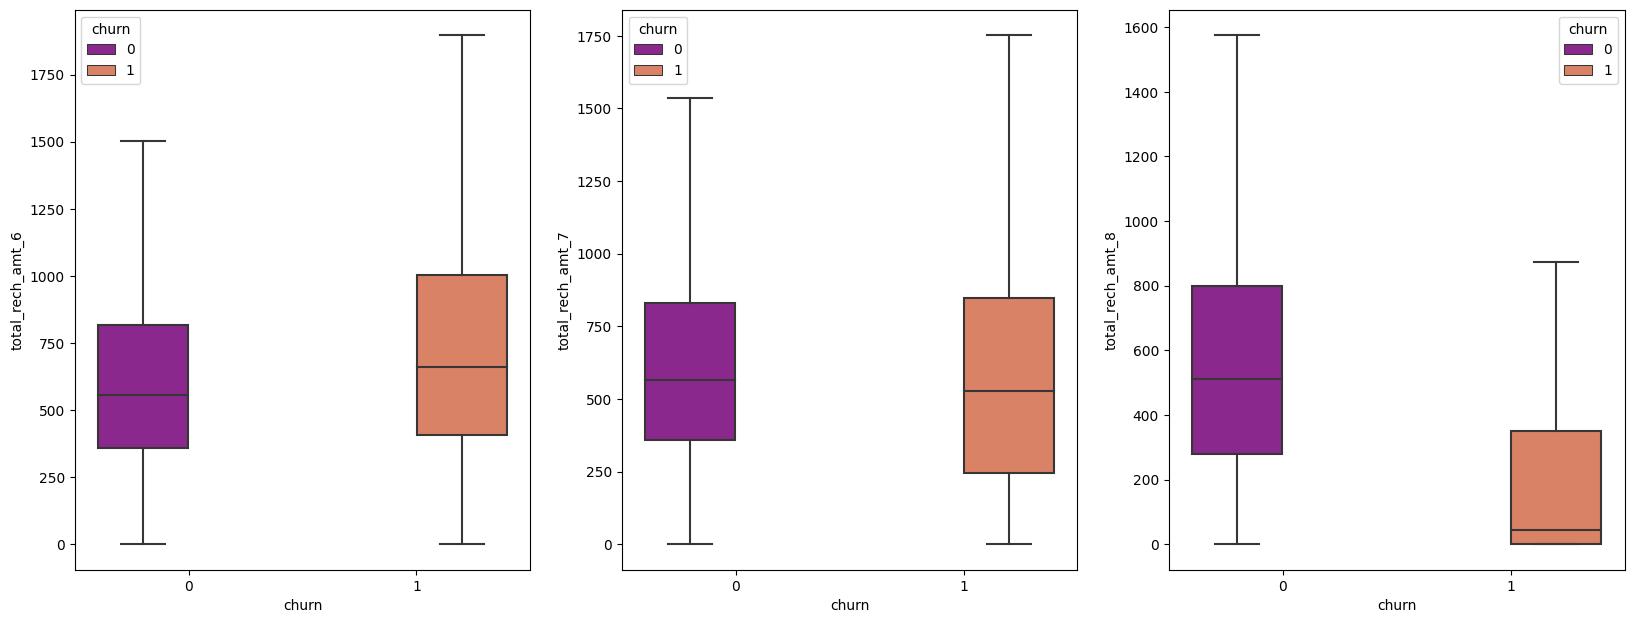

In [ ]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt')

**Analysis:** We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase)

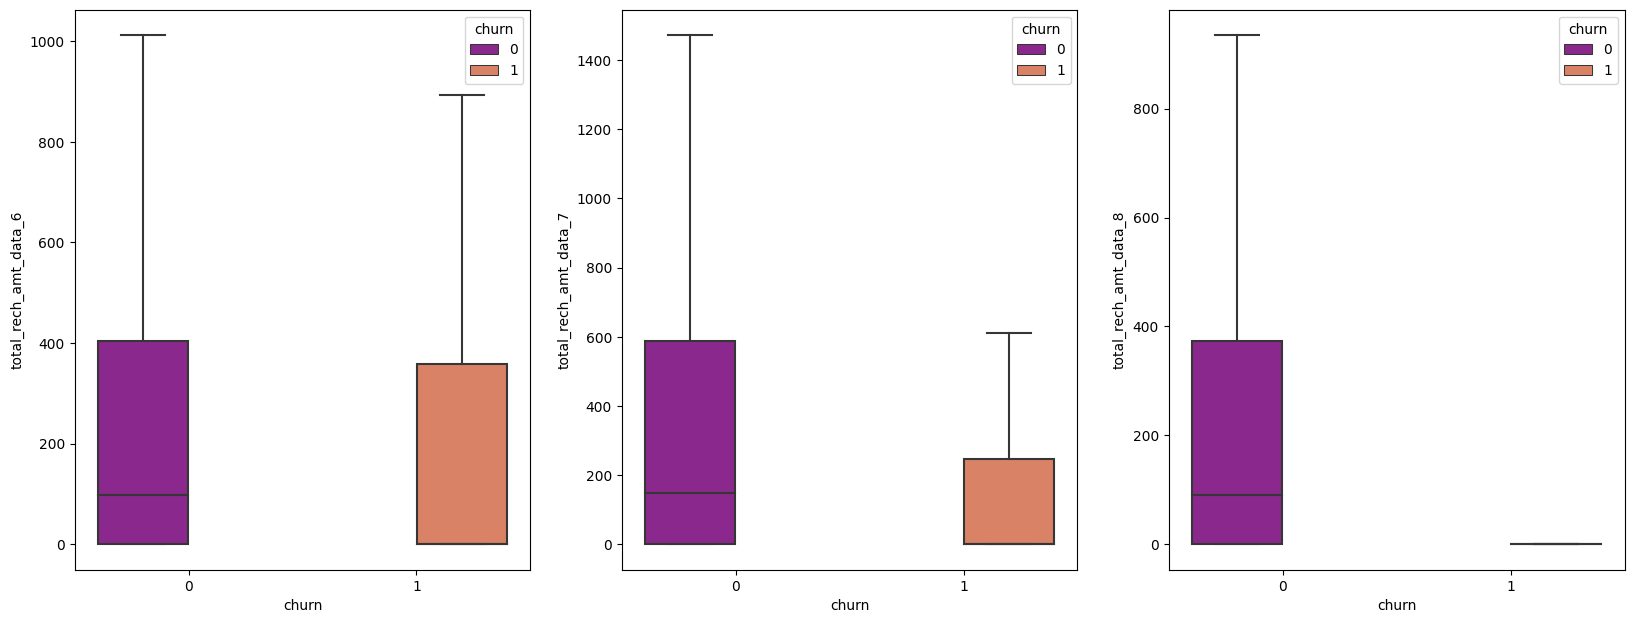

In [ ]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_amt_data')

**Analysis:** We can see that there is a huge drop in total recharge amount for data in the 8th month (action phase) for churned customers.

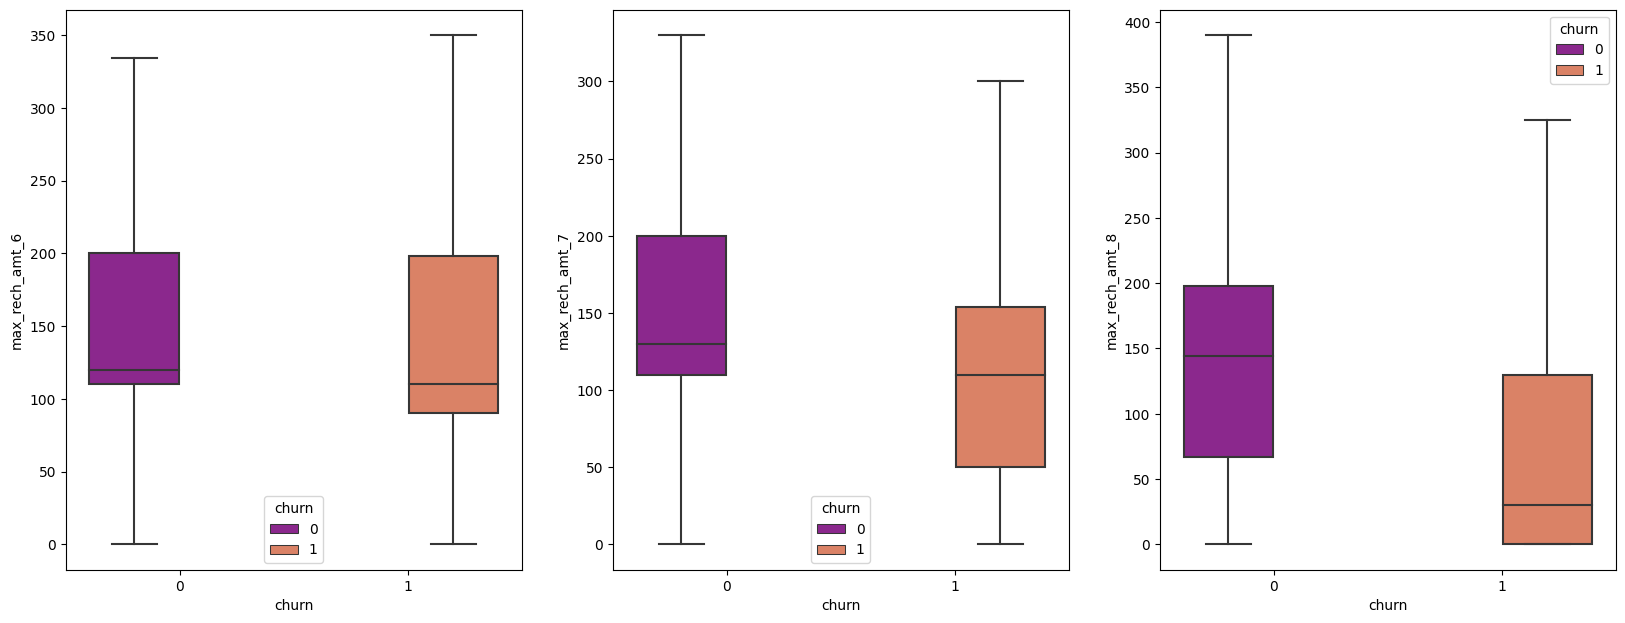

In [ ]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')

**Analysis:** We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

In [ ]:
# Let's check other recharge related variables:
other_recharge = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [ ]:
# lets check the % of NA values for other recharge related variables
100*telecom_high_val_customer.loc[:,other_recharge].isnull().sum()/len(telecom_high_val_customer)

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.112443
max_rech_data_7     43.117551
max_rech_data_8     46.799987
dtype: float64

In [ ]:
telecom_high_val_customer.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16740.000000,17038.000000,15935.000000
mean,139.804002,140.444712,136.353373
std,118.892926,120.295284,119.571138
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


**Analysis:** We see that the minimum value is 1 while the max is 1555 across months, which indicate the missing values are where no recharges happened for the data, Filling the missing values by 0 , means no recharge.

In [ ]:
telecom_high_val_customer.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_high_val_customer.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

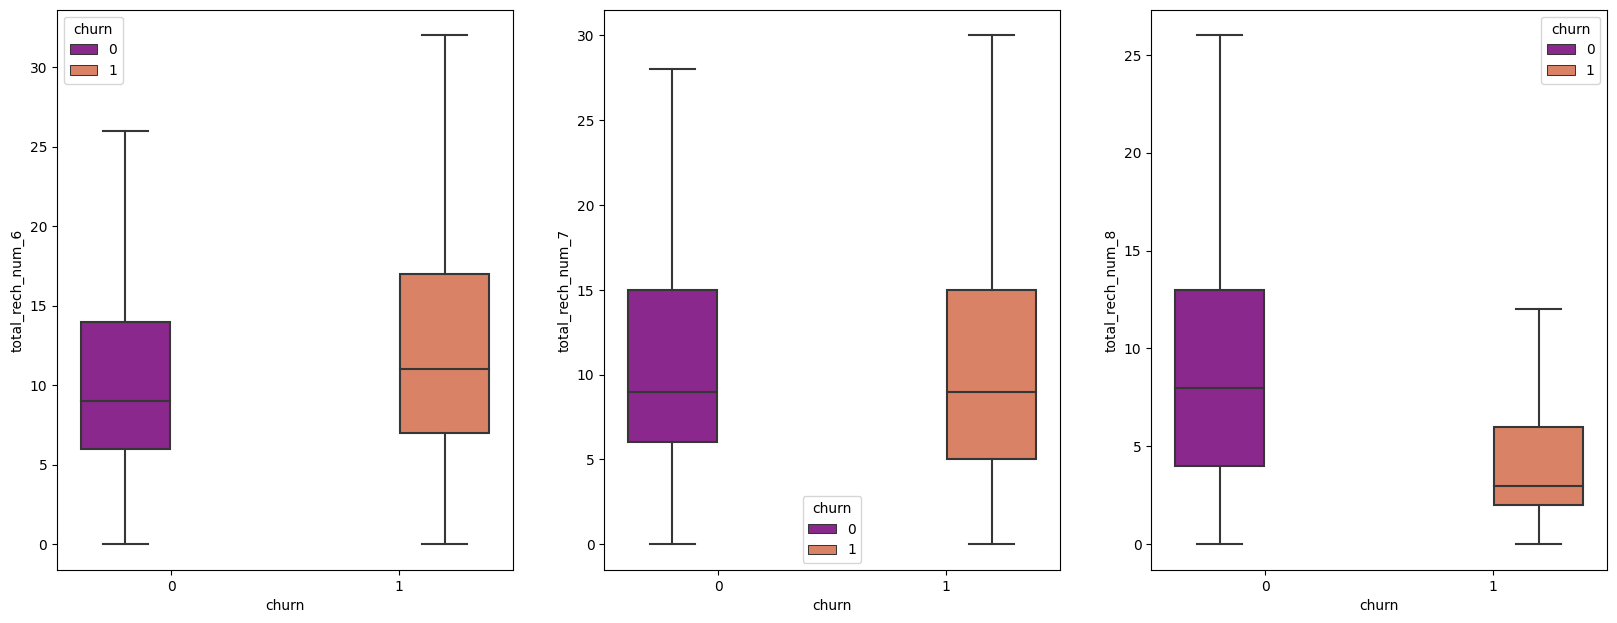

In [ ]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

**Analysis:** We can see that there is a huge drop in total recharge number in the 8th month (action phase) for churned customers.

#### 2.  2G and 3G usage related attributes 

In [ ]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [ ]:
#Checking Null value
100*telecom_high_val_customer.loc[:,monthly_subcription_2g_3g].isnull().sum()/len(telecom_high_val_customer.loc[:,monthly_subcription_2g_3g])

monthly_2g_6    0.0
monthly_2g_7    0.0
monthly_2g_8    0.0
monthly_3g_6    0.0
monthly_3g_7    0.0
monthly_3g_8    0.0
dtype: float64

#### 3. Minutes of usage - voice calls

In [ ]:
mou_cols = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('mou')]

In [ ]:
#Checking Null value
100*telecom_high_val_customer.loc[:,mou_cols].isnull().sum()/len(telecom_high_val_customer.loc[:,mou_cols])

onnet_mou_6     1.809502
onnet_mou_7     1.789470
onnet_mou_8     3.912797
offnet_mou_6    1.809502
offnet_mou_7    1.789470
                  ...   
spl_ic_mou_7    1.789470
spl_ic_mou_8    3.912797
isd_ic_mou_6    1.809502
isd_ic_mou_7    1.789470
isd_ic_mou_8    3.912797
Length: 81, dtype: float64

**Analysis:** So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero

In [ ]:
# replaceing null values by 0 for minutes of usage variables
telecom_high_val_customer.loc[:,mou_cols] = telecom_high_val_customer.loc[:,mou_cols].replace(np.NaN,0)

In [ ]:
mou_og_cols6 = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [ ]:
telecom_high_val_customer.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,26.596033,84.574122,163.309546,6.348347,1.577380,254.240239,165.897941,179.439168,1.806292,347.147123,2.174995,5.825077,610.058005
std,116.274169,228.962993,250.218928,22.139546,6.308138,378.546516,403.990737,409.143255,11.988810,608.845412,45.888834,17.579228,691.178402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.380000,19.210000,0.000000,0.000000,32.260000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,116.640000
50%,0.000000,24.360000,77.260000,0.000000,0.000000,124.590000,2.710000,16.360000,0.000000,45.080000,0.000000,0.230000,410.630000
75%,0.000000,78.060000,209.030000,4.230000,0.000000,332.310000,109.560000,154.540000,0.000000,465.290000,0.000000,5.210000,859.030000
max,3775.110000,6431.330000,4729.740000,1466.030000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


### Plotting Heat Map 

In [ ]:
def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

#### Checking for outgoing mou variables 

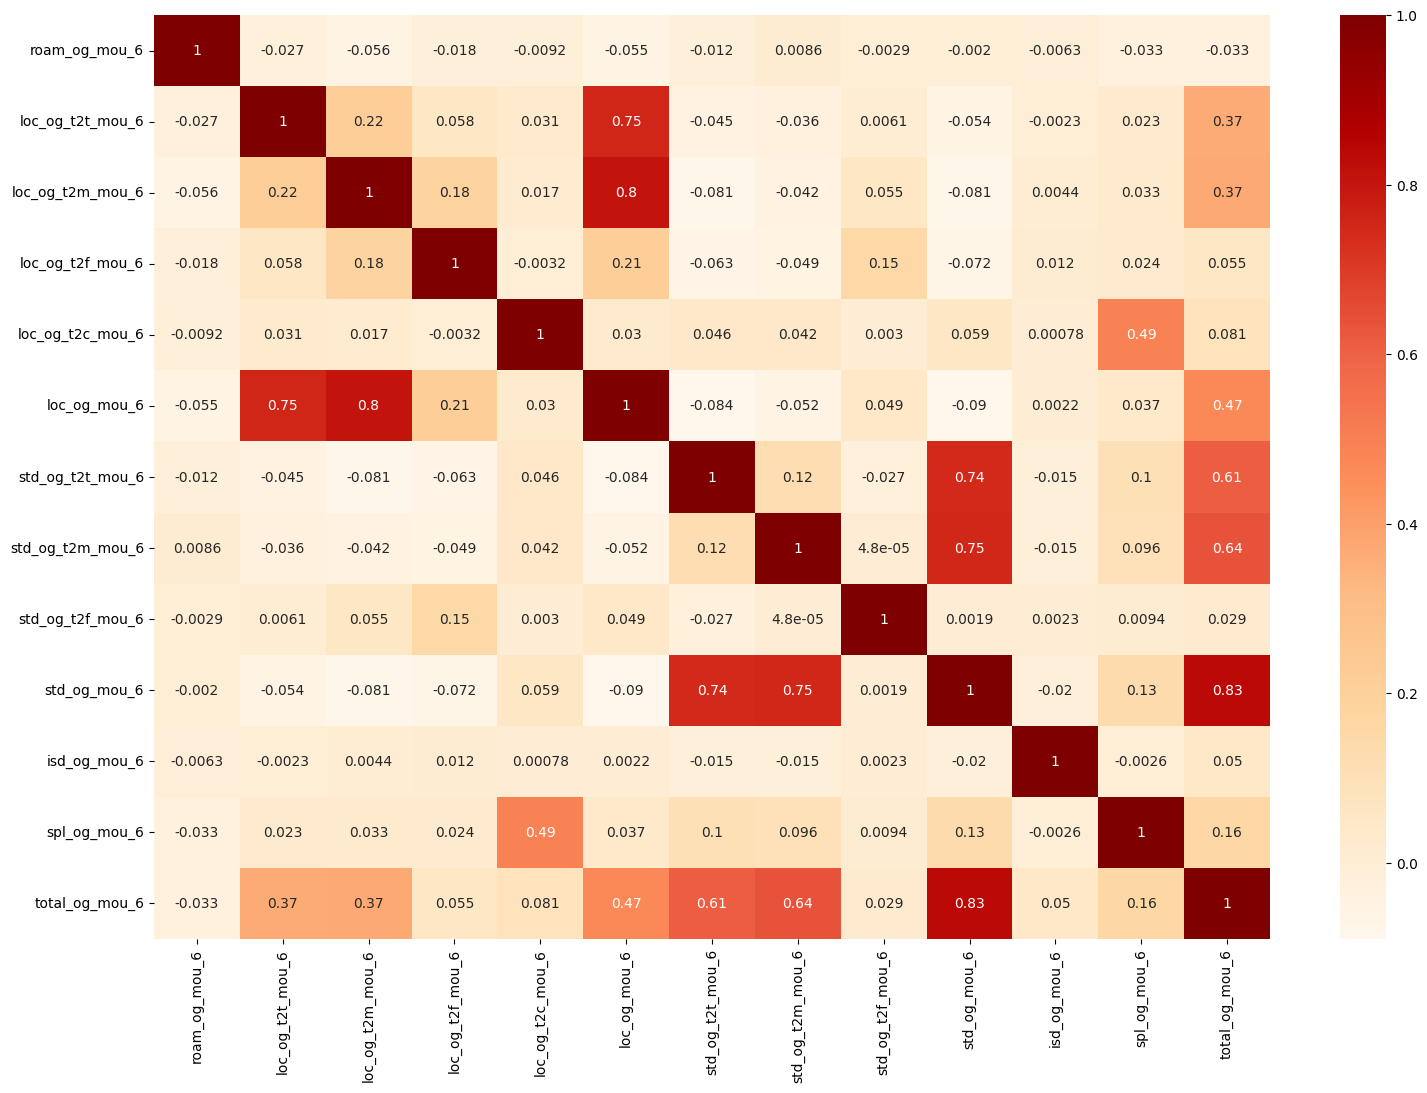

In [ ]:
heatmap(18,12,telecom_high_val_customer.filter(mou_og_cols6))

In [ ]:
#Dropping highly corelated attributes

list_total_og_cols = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
telecom_high_val_customer.drop(list_total_og_cols,axis=1,inplace=True)

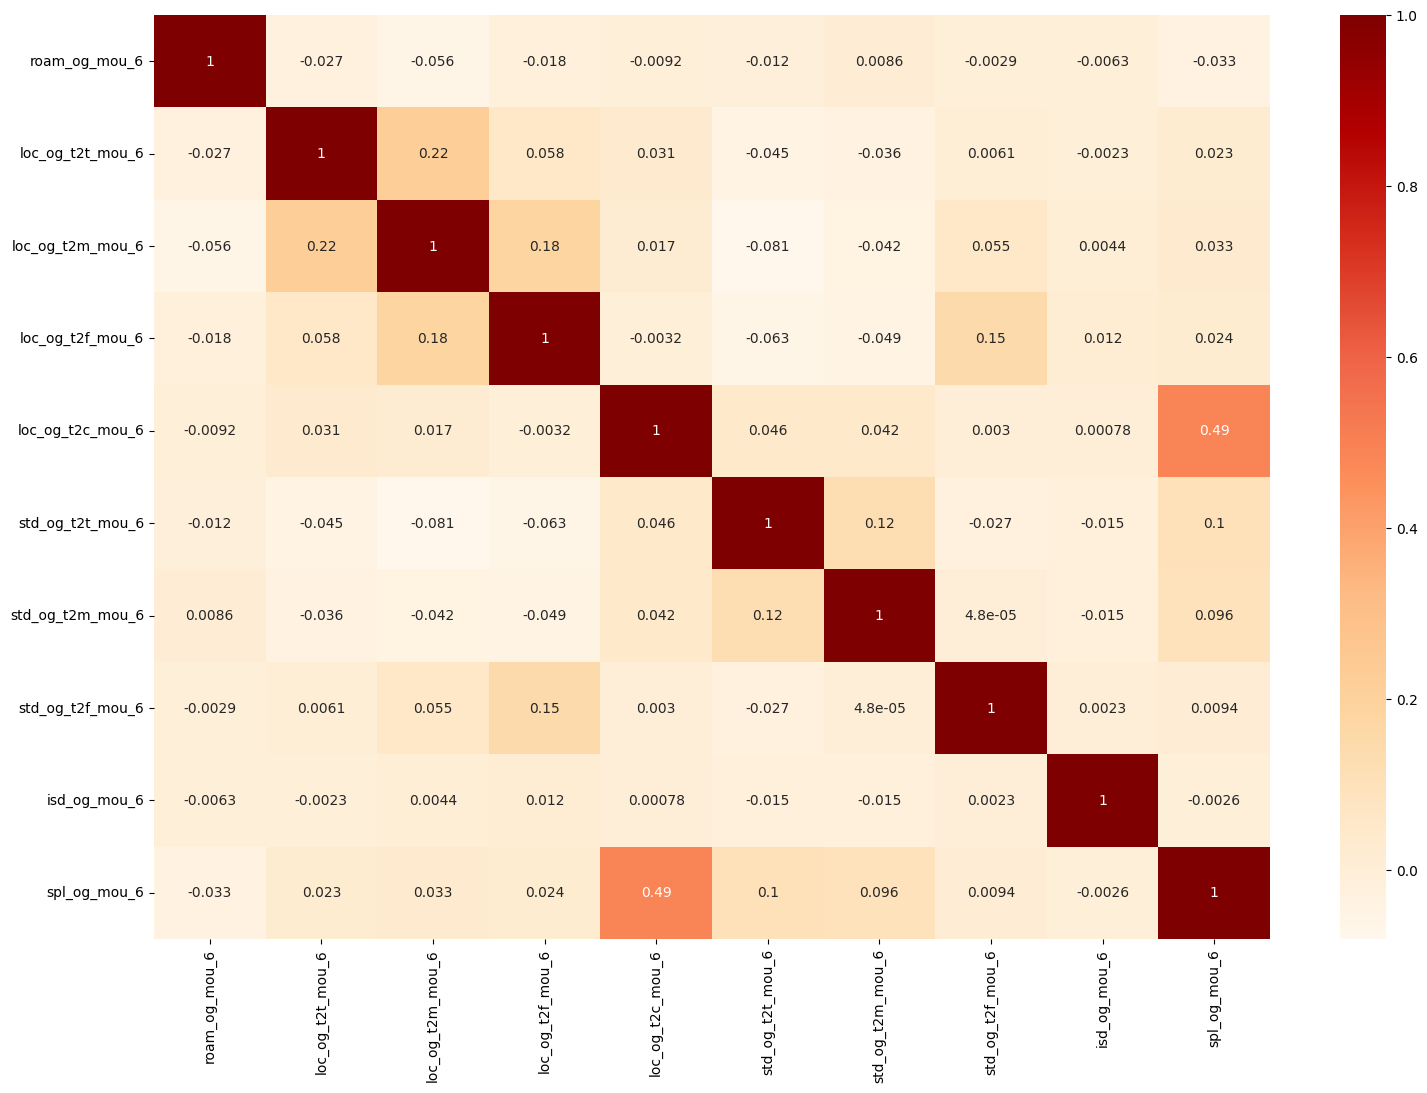

In [ ]:
heatmap(18,12,telecom_high_val_customer.filter(mou_og_cols6))

#### Checking for incoming mou variables 

In [ ]:
mou_ic_cols6 = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('.*_ic_.*mou_6',regex=True)]

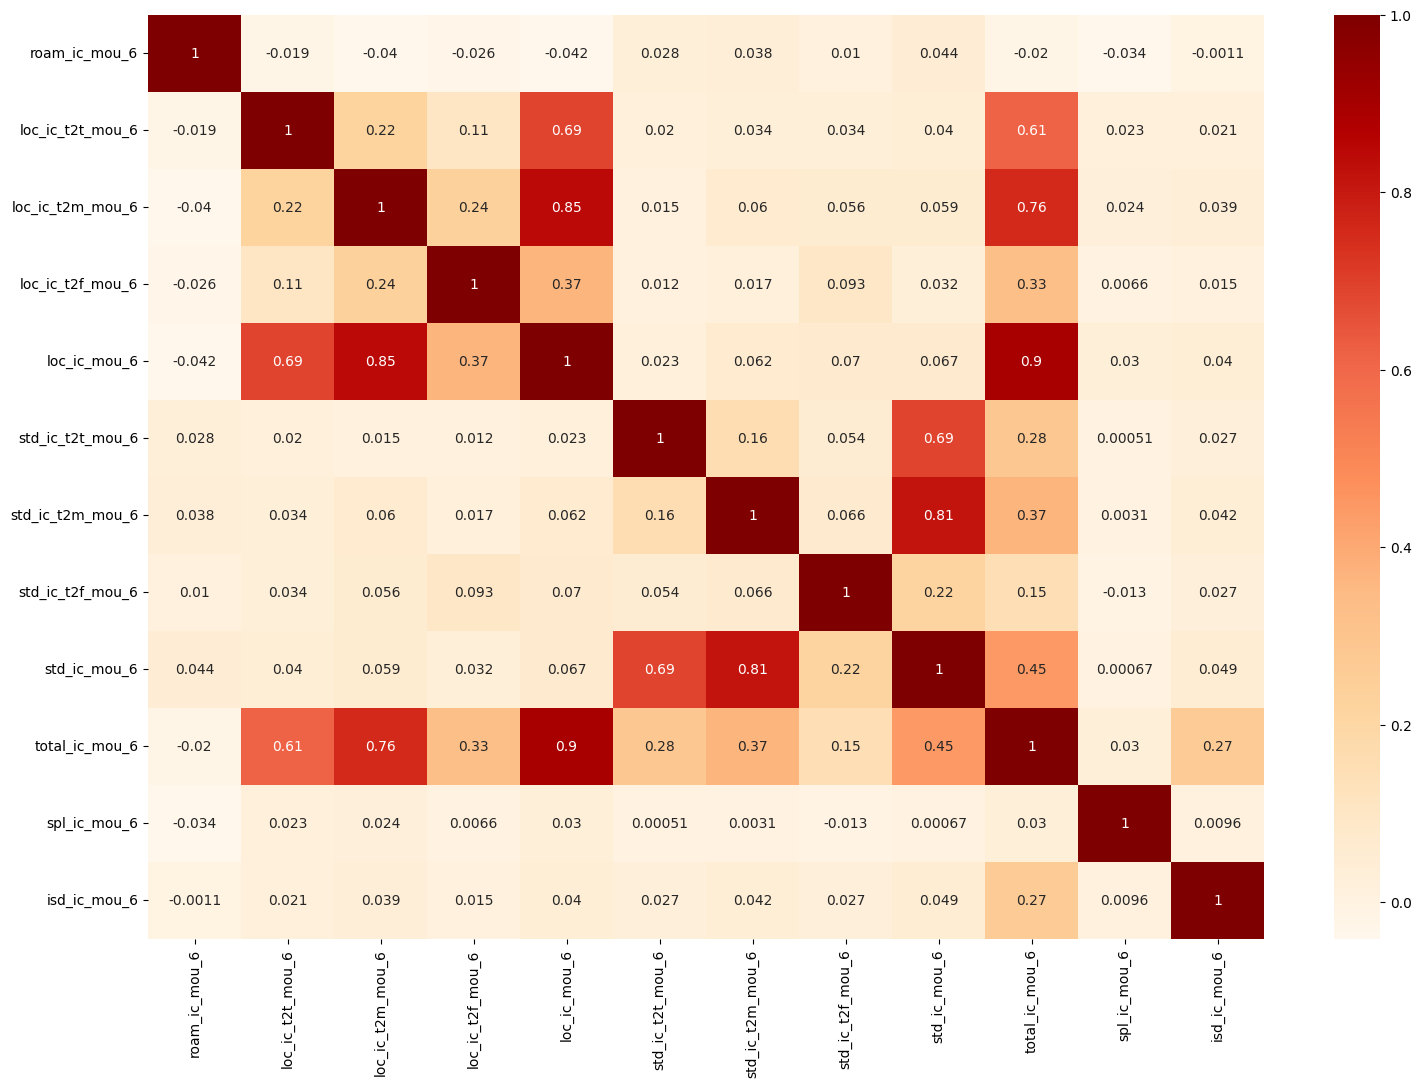

In [ ]:
heatmap(18,12,telecom_high_val_customer.filter(mou_ic_cols6))

In [ ]:
#Dropping highly corelated attributes
list_total_ic_cols = telecom_high_val_customer.columns[telecom_high_val_customer.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
telecom_high_val_customer.drop(list_total_ic_cols,axis=1,inplace=True)

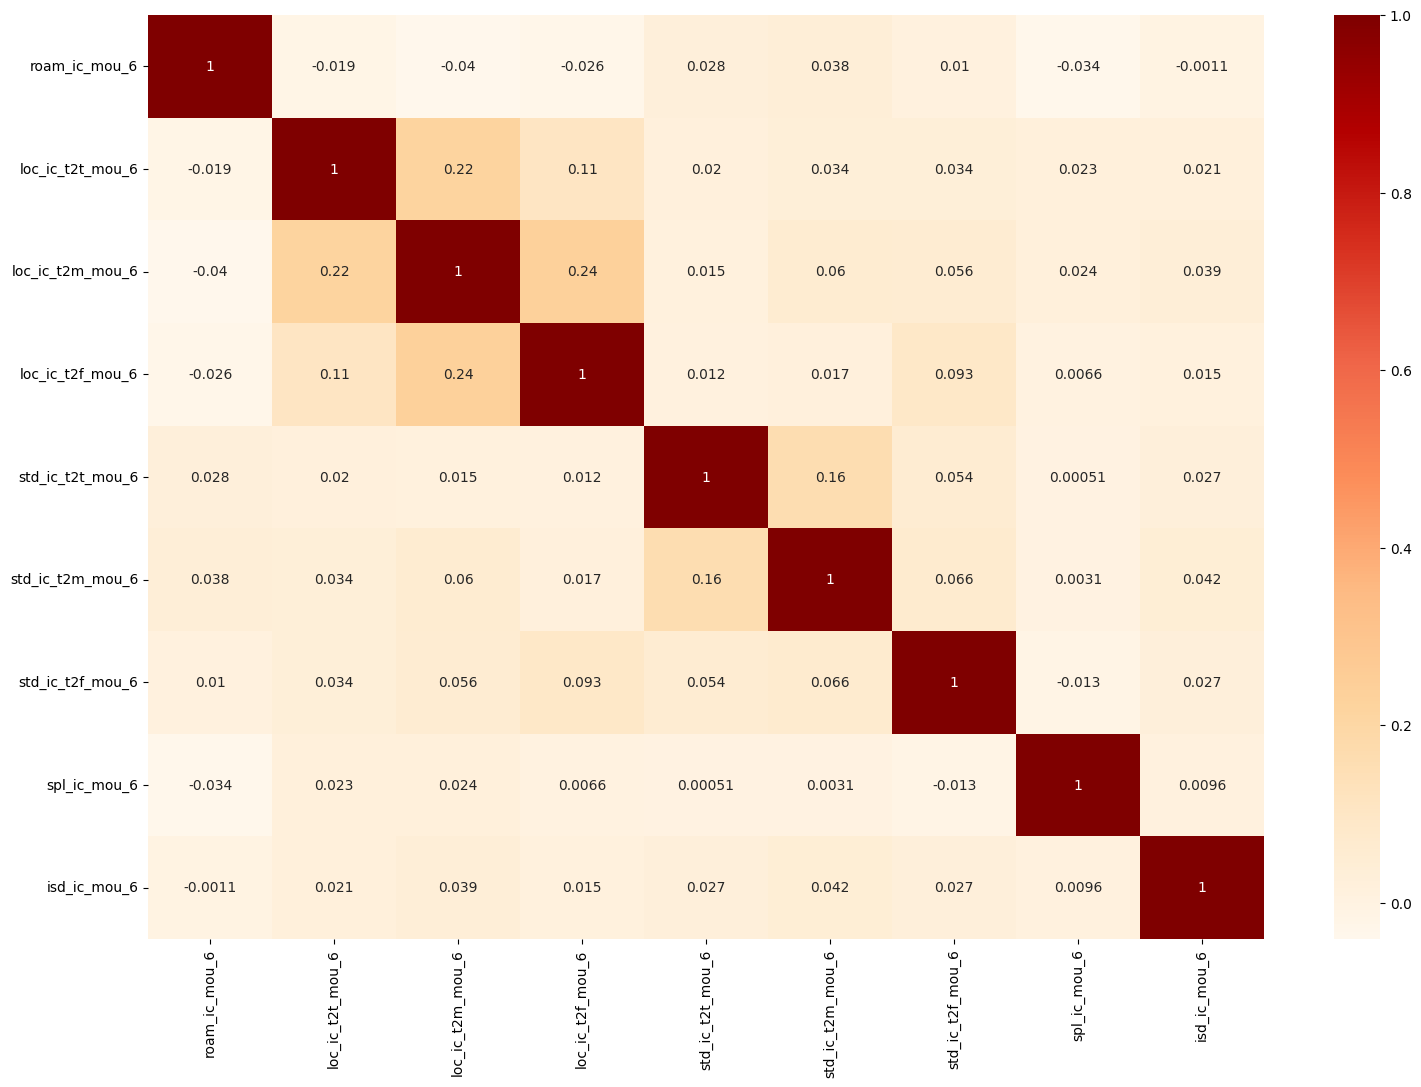

In [ ]:
heatmap(18,12,telecom_high_val_customer.filter(mou_ic_cols6))

#### 4. Tenure Analysis for Customers

In [ ]:
tenure_data = telecom_high_val_customer.copy()
tenure_data['tenure'] = tenure_data['aon']/30

In [ ]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

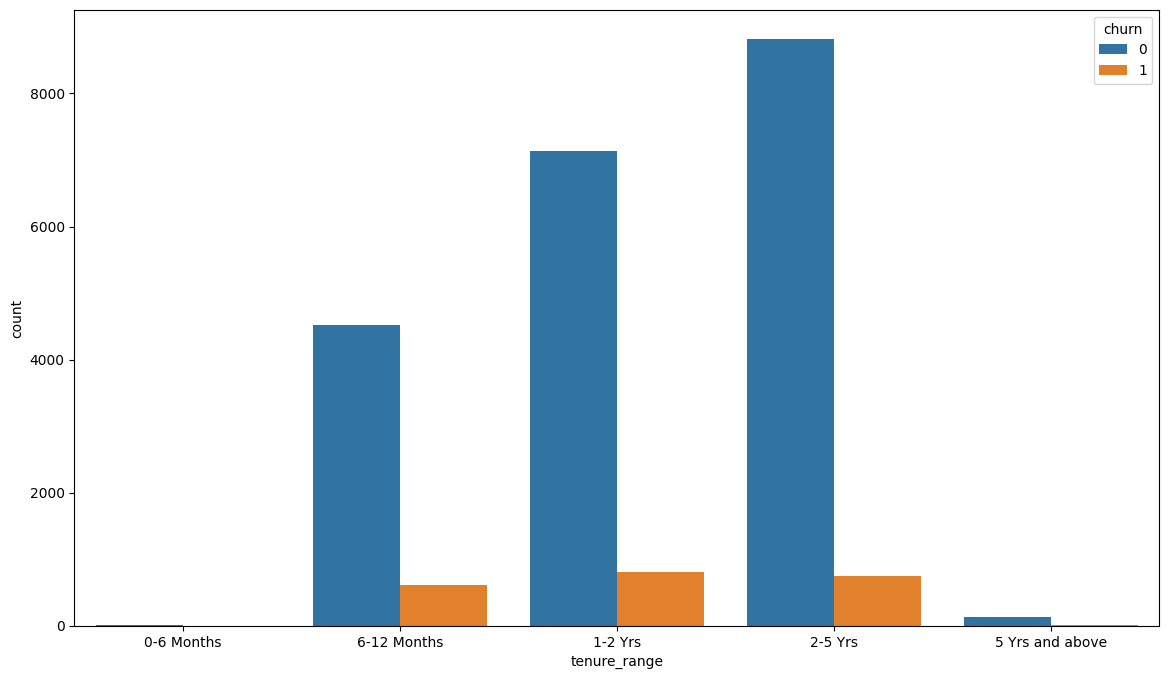

In [ ]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data)
plt.show()

### Checking columns with more than 30% NA values 

In [ ]:
#Drop Columns with > 30% of missing values and not for 9th Month
columns = telecom_high_val_customer.columns
percent_missing = telecom_high_val_customer.isnull().sum() * 100 / len(telecom_high_val_customer)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

drop_col = missing_value_df.loc[(missing_value_df["percent_missing"] > 30.0)]["column_name"]
drop_col

date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6                    night_pck_user_6
night_pck_user_7                    night_pck_user_7
night_pck_user_8                    night_pck_user_8
fb_user_6                                  fb_

In [ ]:
telecom_high_val_customer.drop(drop_col, axis=1, inplace=True)
telecom_high_val_customer.shape

(29953, 125)

In [ ]:
# Checking missing values percentages if any

telecom_null_check = 100*telecom_high_val_customer.loc[:].isnull().sum()/len(telecom_high_val_customer)
df = pd.DataFrame(telecom_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df.loc[df['Null_Percentage']!=0]

,Null_Percentage
og_others_6,1.809502
og_others_7,1.789470
og_others_8,3.912797
ic_others_6,1.809502
ic_others_7,1.789470
ic_others_8,3.912797
date_of_last_rech_6,0.243715
date_of_last_rech_7,0.327179
date_of_last_rech_8,1.943044


#### Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis

In [ ]:
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']

In [ ]:
for i in numberic_col:
    telecom_high_val_customer.loc[telecom_high_val_customer[i].isnull(),i]=0

#### Derive new feature by combining most of the columns from month 6 and 7 as they are part of single phase Good

In [ ]:
telecom_final = telecom_high_val_customer.copy()
print(telecom_final.shape)
telecom_final.head(5)

(29953, 125)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,315,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,604,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0,0


In [ ]:
telecom_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
telecom_final.drop(telecom_high_val_customer.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_final.shape)

col_list = telecom_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_final[avg_col_name] = (telecom_final[col_6]  + telecom_final[col_7])/ 2

(29953, 121)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
total_rech_amt_data


In [ ]:
col_list_to_drop = telecom_final.filter(regex='_6|_7')
telecom_final.drop(col_list_to_drop,axis=1,inplace=True)
print (telecom_final.shape)

(29953, 83)


In [ ]:
telecom_final.head(5)

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,...,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.0,252.0,252.0,15.725,117.165,0.0,0.0,1.0,0.0,252.0
7,7000701601,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,...,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
8,7001524846,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,...,1.0,77.0,88.5,178.000,375.475,0.5,0.5,0.0,0.0,177.0
21,7002124215,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,...,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
23,7000887461,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,...,1.0,89.5,178.0,0.240,299.545,0.0,0.0,1.0,0.0,356.0


##  Modelling

#### Splitting Data into Training and Test Sets 

In [ ]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_final.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_final['churn']

y.head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int64

In [ ]:
scaler = StandardScaler()
X_col = X.columns
X_scaled = scaler.fit_transform(X)
X_scale_final = pd.DataFrame(X_scaled, columns=X_col)

In [ ]:
def getTrainTestSplit():
    return train_test_split(X_scale_final,y, train_size=0.7,test_size=0.3,random_state=100)

In [ ]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = getTrainTestSplit()

### PCA : Principal Component Analysis

#### Note - 
- While computng the principal components, we must not include the entire dataset. Model building is all about doing well on the data we haven't seen yet!
- So we'll calculate the PCs using the train data, and apply them later on the test data

In [ ]:
X_train.shape

(20967, 81)

In [ ]:
pca = PCA(random_state=42)

In [ ]:
pca.fit(X_train)

PCA(random_state=42)

#### Components from the PCA

In [ ]:
pca.components_

array([[ 1.36146202e-02, -1.02688278e-01, -9.78458693e-02, ...,
         2.24253524e-01,  8.98463003e-02,  2.02710350e-01],
       [ 3.06226204e-01,  1.11137752e-01,  2.08220096e-01, ...,
         7.52752519e-02, -5.34397920e-02, -5.29469974e-02],
       [ 1.54487177e-01,  1.12975662e-01,  1.15993408e-01, ...,
        -3.11003403e-02,  1.66301206e-01,  2.08939762e-01],
       ...,
       [ 1.54270804e-03,  3.07392232e-01,  3.14328213e-01, ...,
         2.41672919e-04,  1.67468085e-05, -3.67824139e-05],
       [-1.41643587e-16, -3.60707563e-15, -3.40607947e-15, ...,
         1.45503461e-01,  2.41523240e-01, -1.42247325e-16],
       [ 0.00000000e+00, -1.88535629e-15, -1.67947952e-15, ...,
        -3.57705867e-02, -5.93760996e-02, -1.38777878e-17]])

In [ ]:
pca.explained_variance_ratio_

array([1.03559838e-01, 9.55089083e-02, 6.35861149e-02, 4.62630567e-02,
       3.91373881e-02, 3.65774904e-02, 3.32217606e-02, 3.08775096e-02,
       2.92649254e-02, 2.76925388e-02, 2.69932786e-02, 2.47399900e-02,
       2.37060643e-02, 2.11333613e-02, 2.03513261e-02, 1.86179552e-02,
       1.76419601e-02, 1.67595105e-02, 1.58622445e-02, 1.52725168e-02,
       1.46651759e-02, 1.43137143e-02, 1.35993050e-02, 1.27916457e-02,
       1.18766558e-02, 1.13510983e-02, 1.11468054e-02, 1.06742586e-02,
       1.00600842e-02, 9.90182011e-03, 9.45442124e-03, 9.33933784e-03,
       9.16839612e-03, 9.04380332e-03, 8.71135526e-03, 8.43997795e-03,
       7.52124754e-03, 6.90424069e-03, 6.57915230e-03, 6.07470850e-03,
       5.43281499e-03, 5.35292043e-03, 4.43210551e-03, 4.34212966e-03,
       4.24292411e-03, 4.06049588e-03, 3.80408605e-03, 3.77412745e-03,
       3.54039555e-03, 3.33159199e-03, 3.31096670e-03, 3.21398405e-03,
       3.14352775e-03, 3.10550703e-03, 3.00193067e-03, 2.82903744e-03,
      

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

#### Making a scree plot for the explained variance

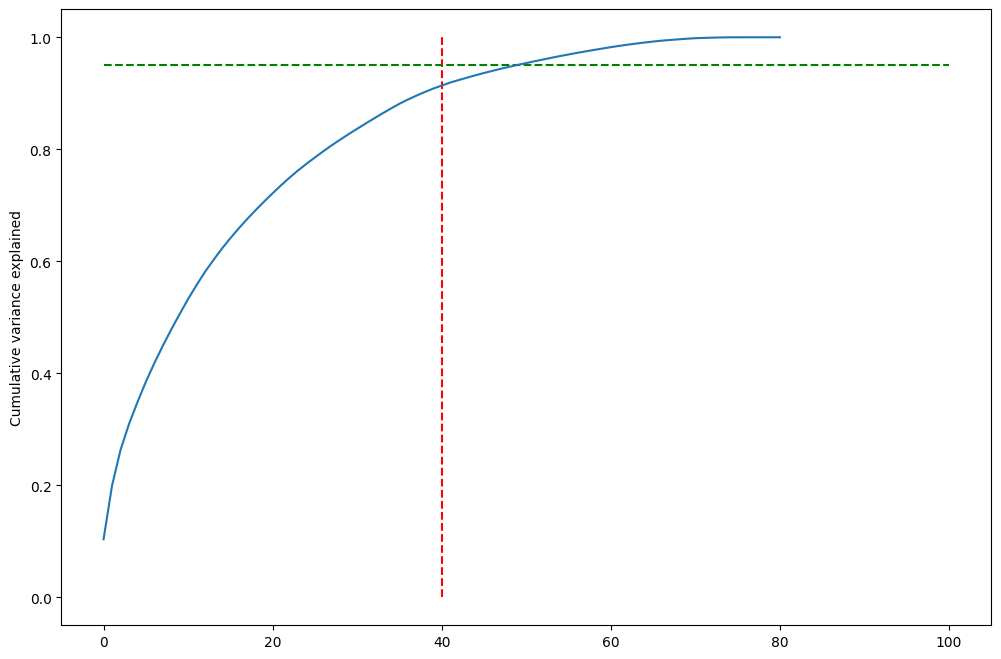

In [ ]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=40, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=100, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

**Analysis:** Looks like 45 components are enough to describe 95% of the variance in the dataset.We'll choose 45 components for our modeling

In [ ]:
pca_final = IncrementalPCA(n_components=45)

In [ ]:
df_train_pca = pca_final.fit_transform(X_train)

In [ ]:
df_train_pca.shape

(20967, 45)

#### Applying the transformation on the test set

In [ ]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8986, 45)

#### Applying logistic regression on the data from our Principal components

In [ ]:
learner_pca = LogisticRegression()

In [ ]:
model_pca = learner_pca.fit(df_train_pca, y_train)

In [ ]:
pred_probs_test = model_pca.predict_proba(df_test_pca)

In [ ]:
df_y_pred = model_pca.predict(df_test_pca)

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print("\n-----------------------  Confusion Matrix --------------------- ")
print(confusion_matrix(y_test, df_y_pred))
print("\n-----------------------  Classification Report ---------------------")
print(classification_report(y_test, df_y_pred))
print("\n -----------------------  Accuracy Score ---------------------")
print(accuracy_score(y_test, df_y_pred))


-----------------------  Confusion Matrix --------------------- 
[[8213   92]
 [ 519  162]]

-----------------------  Classification Report ---------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8305
           1       0.64      0.24      0.35       681

    accuracy                           0.93      8986
   macro avg       0.79      0.61      0.66      8986
weighted avg       0.92      0.93      0.92      8986


 -----------------------  Accuracy Score ---------------------
0.9320053416425551


# Random Forest

#### Let's first fit a random forest model with default hyperparameters.

In [ ]:
X_train.shape

(20967, 81)

#### Default Hyperparameters
Let's first fit a random forest model with default hyperparameters.

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [ ]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
# Making predictions
predictions = rfc.predict(X_test)

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [ ]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8305
           1       0.76      0.45      0.56       681

    accuracy                           0.95      8986
   macro avg       0.86      0.72      0.77      8986
weighted avg       0.94      0.95      0.94      8986



#### Confusion  matrix

In [ ]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8209   96]
 [ 377  304]]


In [ ]:
print(accuracy_score(y_test,predictions))

0.9473625639884264


### Paramater Tuning. 

Let's tune few hyper parameters to see if there is any improvement in the overall performance of the model.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Folds for k-fold CV
n_folds = 5

## Lets define a generic method to tune different parameters.
def tune_model_with_parameter(param) :
    rf = RandomForestClassifier()
    
    rf = GridSearchCV(rf, param, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
    rf.fit(X_train, y_train)
    return rf

## We will also define a method to plot the graph of model after tuning
def plot_the_model_performance_after_tuning(modelParam, model, results):
    # plotting accuracies with given param
    plt.figure()
    plt.plot(results[modelParam], 
             results["mean_train_score"], 
             label="training accuracy")
    plt.plot(results[modelParam], 
             results["mean_test_score"], 
             label="test accuracy")
    plt.xlabel(modelParam)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

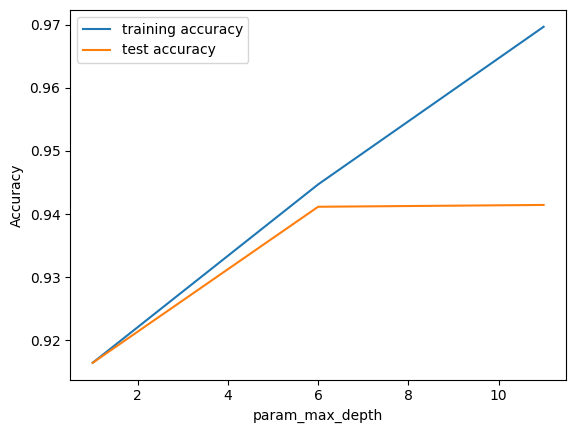

In [ ]:
#let's try to tune max_depth first.
params = {'max_depth': range(1, 15, 5)}
rf = tune_model_with_parameter(params)
results = rf.cv_results_
plot_the_model_performance_after_tuning("param_max_depth", rf, results)

**Analysis:** We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant. The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest. 6 value has peek convergens and can be used for grid veiw search.

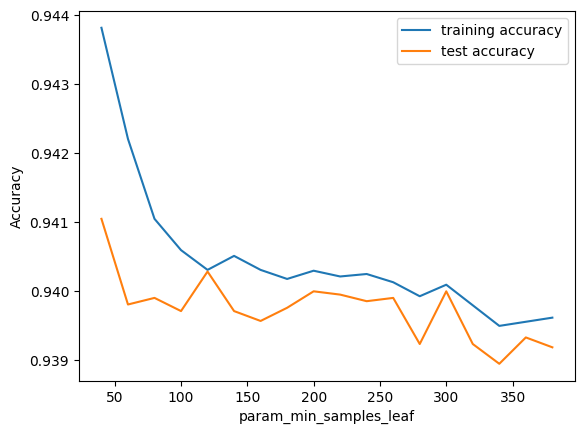

In [ ]:
#let's try optimize the min_samples_leaf to control depth of the tree
params = {'min_samples_leaf': range(40, 400, 20)}
rf = tune_model_with_parameter(params)
results = rf.cv_results_
plot_the_model_performance_after_tuning("param_min_samples_leaf", rf, results)

**Analysis:** We can see that the model starts to overfit as value is decrease the value of min_samples_leaf. 100 seems to be a good range and that will be used in grid search.

In [100]:
#Finally let's also try optimize the minimum samples in each node by tuning min_samples_split
params = {'min_samples_split': range(100, 500, 25)}
rf = tune_model_with_parameter(params)
results = rf.cv_results_
plot_the_model_performance_after_tuning("param_min_samples_split", rf, results)

**Analysis:** Score almost remain the same with very low dip throught the range. We will use 1000 for grid view search.

In [ ]:
# Based on the graphs from above we know appropriate params for the properties. 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = getTrainTestSplit()

final_model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=6,
                                  min_samples_leaf=100, 
                                  min_samples_split=150,
                                  n_estimators=1000,
                                  oob_score = True, n_jobs = -1,
                                  random_state =10,
                                  max_features = 20,
                                  max_leaf_nodes = 30)
final_model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = final_model_rf.predict(X_test)

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print("\n-----------------------  Confusion Matrix --------------------- ")
print(confusion_matrix(y_test, df_y_pred))
print("\n-----------------------  Classification Report ---------------------")
print(classification_report(y_test, df_y_pred))
print("\n -----------------------  Accuracy Score ---------------------")
print(accuracy_score(y_test, df_y_pred))


-----------------------  Confusion Matrix --------------------- 
[[8213   92]
 [ 519  162]]

-----------------------  Classification Report ---------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8305
           1       0.64      0.24      0.35       681

    accuracy                           0.93      8986
   macro avg       0.79      0.61      0.66      8986
weighted avg       0.92      0.93      0.92      8986


 -----------------------  Accuracy Score ---------------------
0.9320053416425551


<Axes: >

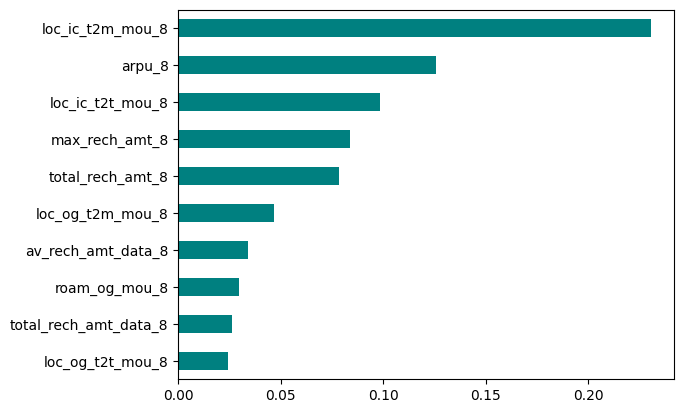

In [ ]:
importances = final_model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X_train.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh',color = 'teal')

Important features ...


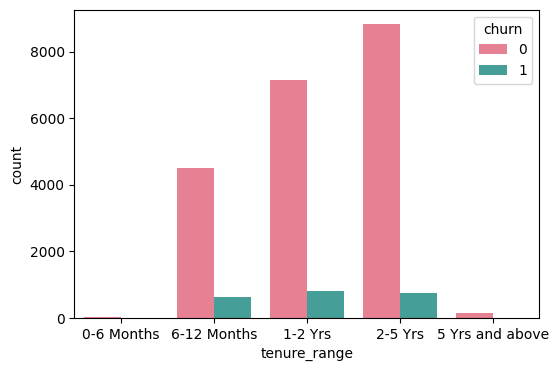

,PC1,PC2,PC3,Feature
0,0.013615,0.306226,0.154487,arpu_8
1,-0.102688,0.111138,0.112976,onnet_mou_8
2,-0.097846,0.208220,0.115993,offnet_mou_8
3,-0.006749,0.052390,0.001505,roam_ic_mou_8
4,-0.021590,0.062553,0.023639,roam_og_mou_8
5,-0.020451,0.089581,0.006271,loc_og_t2t_mou_8
6,-0.022742,0.167355,-0.034601,loc_og_t2m_mou_8
7,0.011691,0.100447,-0.094795,loc_og_t2f_mou_8
8,-0.016508,0.018951,0.084266,loc_og_t2c_mou_8
9,-0.104055,0.072047,0.124452,std_og_t2t_mou_8


In [ ]:
print("Important features ...")
plt.figure(figsize=(6,4))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("husl"))
plt.show()


col = list(X_scale_final.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

### Business Insights

Less number of **high value customer** are churing but for last **6 month** no new high valued customer is onboarded which is concerning and company should concentrate on that aspect.

Customers with less than **4 years** of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group.

**Average revenue per user** seems to be most important feature in determining churn prediction.

**Incoming and Outgoing Calls** on romaing for 8th month are strong indicators of churn behaviour